# Test 20

In this test, I want to evaluate the stability of AF $\pm 2$ states in both sizes

In [2]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
#mpl.use('pgf')
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Preparing smol state

In [4]:
quench_time = 120*ureg.s
rotation_time = 0*ureg.s
total_time = quench_time + rotation_time
data_path = "../data/test20/"
runs = 10

smol_params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":100e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":0.1*ureg.ms,
    "max_field":10*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

smol_params["lattice_constant"] = smol_params["trap_sep"]+(2*smol_params["particle_radius"]+1*ureg.um)*np.sqrt(2)
smol_params["size"] = 10

In [69]:
gspath = '../data/test16'
smolaf = pd.read_csv(os.path.join(gspath,'smolaf.csv'),index_col=0)

particle = ice.particle(
    radius = smol_params['particle_radius'],
    susceptibility = smol_params['particle_susceptibility'],
    diffusion = smol_params["particle_diffusion"],
    temperature = smol_params["particle_temperature"],
    density = smol_params["particle_density"]
)
    
trap = ice.trap(
    trap_sep = smol_params["trap_sep"], 
    height = smol_params["trap_height"],
    stiffness = smol_params["trap_stiffness"]
)
    
smol_params['particle'] = particle
smol_params['trap'] = trap

smol_col = aux.get_colloids_from_ctrj2(smolaf,smol_params)

In [70]:
list(list(i for i in range(100,110,20)))

[100]

In [71]:
col1 = smol_col.copy(deep=True)
flips = [ i+j for i in range(100,110) for j in range(0,100,20) ]
col1 = mc.flip_colloids(col1,indices=flips)

100%|██████████| 200/200 [00:00<00:00, 282.80it/s]


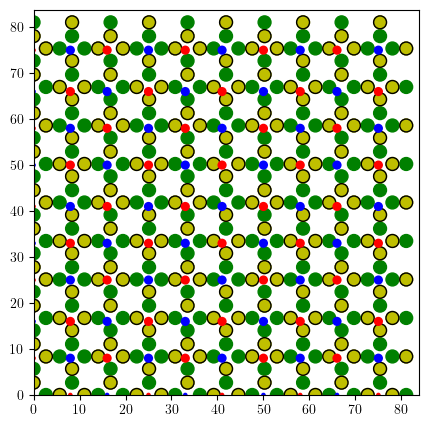

In [72]:
fig, ax = plt.subplots(figsize=(5,5))

v = ice.vertices()
v = v.colloids_to_vertices(col1)

col1.display(ax)
v.display(ax,dpl_scale=0.5,dpl_width=2.5,circle_scale=0.5)
plt.show()

In [55]:
col1.to_ctrj().to_csv('../data/test20/smoaf2.csv')

In [49]:
E0 = smol_col.calculate_energy(B=field) / 1e5
E1 = col1.calculate_energy(B=field) / 1e5

In [50]:
E0 - E1

-0.4742011666530481 <Unit('nanometer * piconewton')>

# Evolution of AF2

In [45]:
def get_md_colloid(params, ctrj, realization):
    
    N = params['size']
    a = params['lattice_constant']
    
    particle = ice.particle(
        radius = params['particle_radius'],
        susceptibility = params['particle_susceptibility'],
        diffusion = params["particle_diffusion"],
        temperature = params["particle_temperature"],
        density = params["particle_density"]
    )
    
    trap = ice.trap(
       trap_sep = params["trap_sep"], 
       height = params["trap_height"],
       stiffness = params["trap_stiffness"]
    )
    
    params['particle'] = particle
    params['trap'] = trap
    
    col = aux.get_colloids_from_ctrj2(ctrj,params)
    
    world = ice.world(
        field = params["max_field"],
        temperature = params["sim_temp"],
        dipole_cutoff = params["sim_dipole_cutoff"],
        boundaries=['p', 'p', 'p']
    )
    
    col.simulation(world,
        name = f"./lammps_files/test{realization}",
        include_timestamp = False,
        targetdir = r".",
        framerate = params["framespersec"],
        timestep = params["dt"],
        run_time = params["total_time"],
        output = ["x","y","z","mux","muy","muz"],
        processors=1)
    
    col.sim.field.fieldx = "v_Bmag"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "0"   

    col.run_simulation()
    col.load_simulation()

    return col   

In [46]:
def jesus_take_the_wheels(params,ctrj,data_path,realization):
    trj_path = os.path.join(data_path,'trj')
    ctrj_path = os.path.join(data_path,'ctrj')

    try:
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass
    
    col = get_md_colloid(params,ctrj,realization)

    col.trj.to_csv(os.path.join(trj_path,f"trj{realization}.csv"))

    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv(os.path.join(ctrj_path,f"ctrj{realization}.csv"))
    
    return None

In [ ]:
smolaf2 = pd.read_csv(os.path.join(data_path,'smolaf2.csv'),index_col=0)
smolaf2

In [47]:
import concurrent.futures

In [ ]:
runs = 5
realizations = list(range(1,runs+1))
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # map the function to the realizations
    results = list(
        executor.map(
            jesus_take_the_wheels,
            [smol_params] * len(realizations),
            [smolaf2] * len(realizations),
            [data_path] * len(realizations),
            realizations,
        )
    )

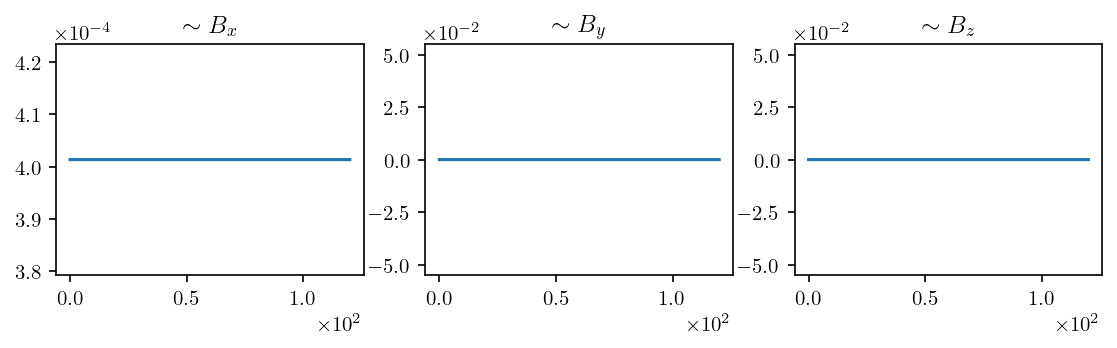

In [5]:
trj_raw = trj = pd.read_csv(os.path.join(data_path,'trj/trj1.csv'), index_col=[0,1])
ctrj_raw = pd.read_csv(os.path.join(data_path,'ctrj/ctrj1.csv'), index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

## AF2 vertex counting

In [52]:
trj_path = os.path.join(data_path,"trj")
ctrj_path = os.path.join(data_path,"ctrj")
vrt_path = os.path.join(data_path,"vertices")

# Get the number of realizations
_, _, files = next(os.walk(trj_path))
realizations = len(files)

for i in range(1,5+1):
    print("========================================")
    print(f"Working on realization {i}")

    # Importing files
    trj_file = os.path.join(trj_path,f"trj{i}.csv")
    print(f"Opening " + trj_file)
    ctrj_file = os.path.join(ctrj_path,f"ctrj{i}.csv")
    print(f"Opening " + ctrj_file)
    trj_raw = trj = pd.read_csv(trj_file, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrj_file, index_col=[0,1])

    # Doing shit with the vertices
    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    vrt_file = os.path.join(vrt_path,f"vertices{i}.csv")
    v.trj_to_vertices(ctrj_raw.loc[frames[::2]])

    print(f"Saving vertices to " + vrt_file)
    v.vertices.to_csv(vrt_file)
    
    clear_output(wait=True)

Working on realization 5
Opening ../data/test20/trj/trj5.csv
Opening ../data/test20/ctrj/ctrj5.csv


100%|██████████| 1200/1200 [05:23<00:00,  3.70it/s]


Saving vertices to ../data/test20/vertices/vertices5.csv


In [54]:
vrt_path = os.path.join(data_path,"vertices/")
vertices = aux.getVerticesDict(vrt_path)
counts = aux.getVerticesCount(vertices)
vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
types = vrt_ts.columns.to_list()[1:]
t = vrt_ts["time"].to_numpy()
vrt_counts = vrt_ts[types].to_numpy()

/home/leogabac/.local/lib/python3.8/site-packages/pandas/core/construction.py:580: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


In [55]:
field = t * params["max_field"].magnitude / quench_time.magnitude
params["max_field"]

5 <Unit('millitesla')>

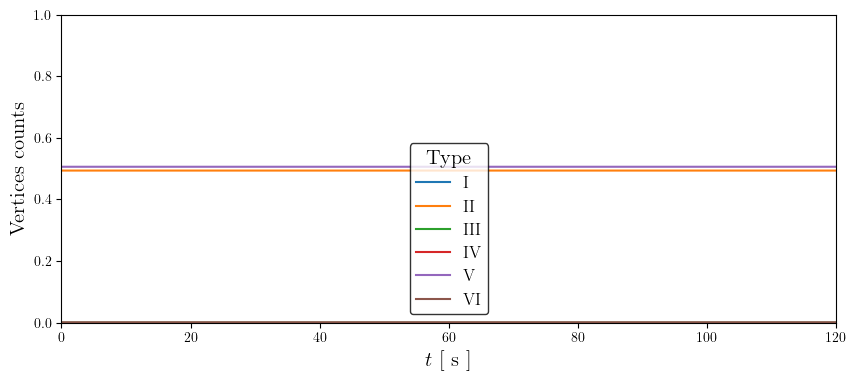

In [57]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(t,vrt_counts[:,0])
ax.plot(t,vrt_counts[:,1])
ax.plot(t,vrt_counts[:,2])
ax.plot(t,vrt_counts[:,3])
ax.plot(t,vrt_counts[:,4])
ax.plot(t,vrt_counts[:,5])

ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black')
ax.set_xlabel("$t$  [ s ] ", fontsize=15)
ax.set_ylabel("Vertices counts", fontsize=15)
ax.set_xlim(0,params['total_time'].magnitude)
ax.set_ylim(0,1)
plt.show()

fig.savefig('../data/vertices_full.pdf', bbox_inches='tight')
fig.savefig('../data/vertices_full.jpeg', dpi=300)

# Preparing Big State

In [5]:
quench_time = 120*ureg.s
rotation_time = 0*ureg.s
total_time = quench_time + rotation_time
data_path = "../data/test20/"
runs = 10

params = {
    "particle_radius":5*ureg.um,
    "particle_susceptibility":0.0576,
    "particle_diffusion":0.125*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":10*ureg.um,
    "trap_height":4*ureg.pN*ureg.nm,
    "trap_stiffness":10e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":1*ureg.ms,
    "max_field":5*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)
params["size"] = 10

In [32]:
sp = ice.spins()

N = params["size"]
a = params["lattice_constant"]
    
# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")

particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"])

trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"])

col = ice.colloidal_ice(sp, particle, trap,
                        height_spread = params["height_spread"], 
                        susceptibility_spread = params["susceptibility_spread"],
                        periodic = params["isperiodic"])

col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a

col1 = col.copy(deep=True)

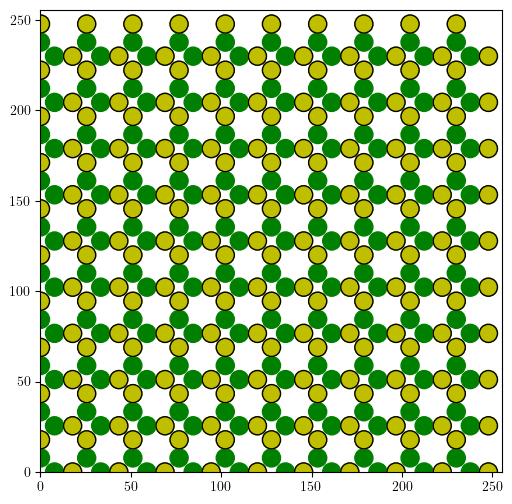

In [33]:
fig, ax = plt.subplots(figsize=(6,6) )
col.display(ax)

In [34]:
flipsv = [100 + k + n for k in range(0,100,10) for n in range(0,10,2)]
flipsh = [0 + k + n for k in range(0,100,10) for n in range(1,10,2)]
flipsh2 = [0 + k + n for k in range(0,100,20) for n in range(0,10,1)]
flips = flipsv + flipsh + flipsh2
col1 = mc.flip_colloids(col1, indices=flips)


In [35]:
v = ice.vertices()
v = v.colloids_to_vertices(col1)

100%|██████████| 200/200 [00:02<00:00, 98.70it/s] 


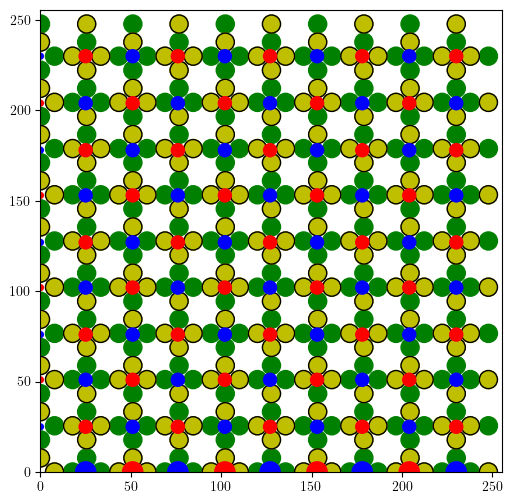

In [36]:
fig, ax = plt.subplots(figsize=(6,6) )
col1.display(ax)
v.display(ax)

In [42]:
col1.to_ctrj().to_csv(os.path.join(data_path,'bigaf2.csv'))

In [41]:
os.path.join(data_path,'bigaf2.csv')

'../data/test20/bigaf2.csv'

## Evolution of big state

In [44]:
bigaf = pd.read_csv(os.path.join(data_path,'bigaf2.csv'),index_col=0)

In [49]:
runs = 5
realizations = list(range(1,runs+1))
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # map the function to the realizations
    results = list(
        executor.map(
            jesus_take_the_wheels,
            [params] * len(realizations),
            [bigaf] * len(realizations),
            [data_path] * len(realizations),
            realizations,
        )
    )

scanning file


 22%|██▏       | 8355574/38352106 [00:00<00:01, 15069978.19it/s]

scanning file


 35%|███▍      | 13414284/38352106 [00:01<00:02, 10057672.85it/s]

scanning file


scanning file


scanning file





 38%|███▊      | 14451472/38352106 [00:01<00:03, 6969698.40it/s] 












 40%|███▉      | 15286217/38352106 [00:01<00:04, 5713558.54it/s]











 42%|████▏     | 15976121/38352106 [00:01<00:04, 4866737.55it/s]








 43%|████▎     | 16552823/38352106 [00:02<00:04, 4513884.99it/s]








 44%|████▍     | 17061730/38352106 [00:02<00:04, 4305769.94it/s]







 46%|████▌     | 17527363/38352106 [00:02<00:05, 4146853.37it/s]





 47%|████▋     | 17962564/38352106 [00:02<00:05, 3999963.87it/s]





 48%|████▊     | 18373780/38352106 [00:02<00:05, 3988531.10it/s]





 49%|████▉     | 18780162/38352106 [00:02<00:05, 3891958.87it/s]





 50%|████▉     | 19175527/38352106 [00:02<00:04, 3907410.83it/s]





 51%|█████     | 19631917/38352106 [00:02<00:04, 4041713.04it/s]






 52%|█████▏    | 20039670/38352106 [00:02<00:04, 3983644.71it/s]





 53%|█████▎    | 20440203/38352106 [00:03<00:04, 3853540.76it/s]





 54%|█████▍    | 20845883/38352106 [00:03<00:04, 3880866.64it/s]

In [51]:
get_md_colloid(params,bigaf,1)

scanning file
